# Vizualization on cars database

In [7]:
import pickle
import os
import numpy as np
import cv2
from skimage import io,draw
import random
from mrcnn.visualize import display_images
from mrcnn import visualize
import pandas as pd

In [8]:
BOXCARS_DATASET_ROOT = "D:\\Master TAID\\Anul2\\MLAV\\Car-Detection-Mask-R-CNN\\DataSet\\BoxCars116k"

#%%

BOXCARS_IMAGES_ROOT = os.path.join(BOXCARS_DATASET_ROOT, "images")
BOXCARS_DATASET = os.path.join(BOXCARS_DATASET_ROOT, "dataset.pkl")
BOXCARS_ATLAS = os.path.join(BOXCARS_DATASET_ROOT, "atlas.pkl")
BOXCARS_CLASSIFICATION_SPLITS = os.path.join(BOXCARS_DATASET_ROOT, "classification_splits.pkl")

In [9]:
class BoxCar():
    def __init__(self):
        self.X = {}
        self.Y = {}
        for part in ("train", "validation", "test"):
            self.X[part] = None
            self.Y[part] = None # for labels as array of 0-1 flags
        self.dataset=self.load_cache(BOXCARS_DATASET)
        self.atlas=self.load_cache(BOXCARS_ATLAS)
        self.split=self.load_cache(BOXCARS_CLASSIFICATION_SPLITS)['hard']
        self.nr_of_classes=len(self.split["types_mapping"])
        self.df=pd.read_pickle(BOXCARS_DATASET)
    
    def load_cache(self,path, encoding="latin-1", fix_imports=True):
        with open(path, "rb") as f:
            return pickle.load(f, encoding=encoding, fix_imports=True)


    
    def initialize_data(self, part):
        assert self.split is not None, "load classification split first"
        assert part in self.X, "unknown part -- use: train, validation, test"
        assert self.X[part] is None, "part %s was already initialized"%part
        data = self.split[part]
        x, y = [], []
        for vehicle_id, label in data:
            num_instances = len(self.dataset["samples"][vehicle_id]["instances"])
            x.extend([(vehicle_id, instance_id) for instance_id in range(num_instances)])
            y.extend([label]*num_instances)
        self.X[part] = np.asarray(x,dtype=int)

        y = np.asarray(y,dtype=int)
        y_categorical = np.zeros((y.shape[0], self.nr_of_classes))
        y_categorical[np.arange(y.shape[0]), y] = 1
        self.Y[part] = y_categorical
    
    
    
    def get_image(self, part,image_id):
        """
        returns decoded image from atlas in RGB channel order
        """
        vehicle_id, instance_id=self.X[part][image_id]
        return cv2.cvtColor(cv2.imdecode(self.atlas[vehicle_id][instance_id], 1), cv2.COLOR_BGR2RGB)
    
    def load_mask(self,part,image_id):
        vehicle_id, instance_id=self.X[part][image_id]
        image=self.get_image(part,image_id)
        height, width = image.shape[:2]
        mask = np.zeros([height, width, 1],dtype=np.uint8)
        start,end=self.getMask2D(part,image_id)
        rr, cc = draw.rectangle(start, end, shape=image.shape[:2])
        mask[rr, cc] = 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
    
    def getMask3D(self,part,index):
        vehicle_id, instance_id=self.X[part][index]
        points=np.array(self.df['samples'][vehicle_id]['instances'][instance_id]['3DBB'], np.int32)
        X=points[:,0]
        Y=points[:,1]
        return X,Y,np.array(points)
    def getMask2D(self,part,index):
        vehicle_id, instance_id=self.X[part][index]
        x1,y1,x2,y2=self.df['samples'][vehicle_id]['instances'][instance_id]['2DBB']
        return (int(y1),int(x1)),(int(y2+y1),int(x2+x1))

In [14]:
data=BoxCar()
data.initialize_data("train")
data.initialize_data("validation")

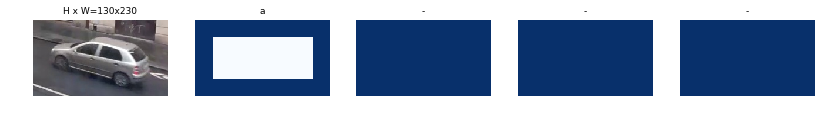

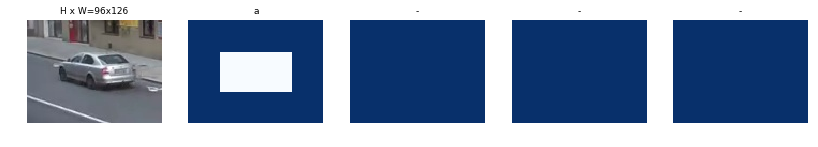

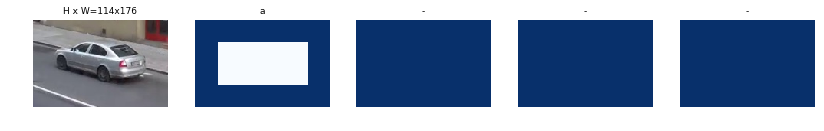

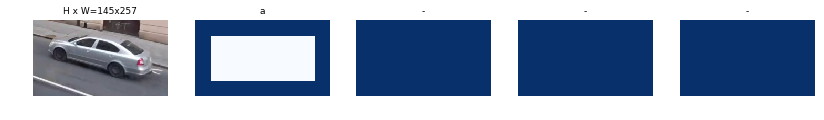

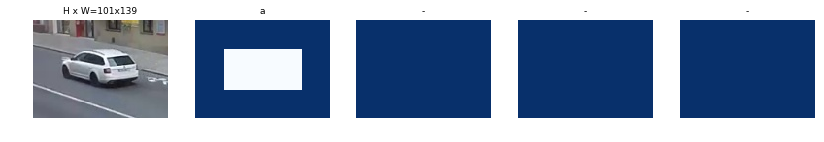

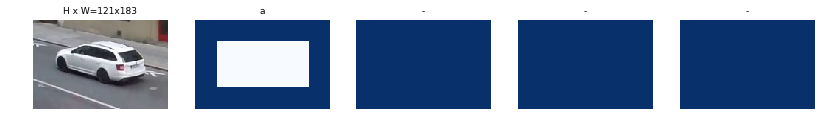

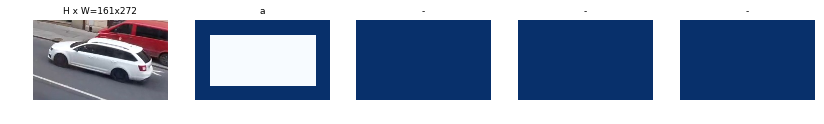

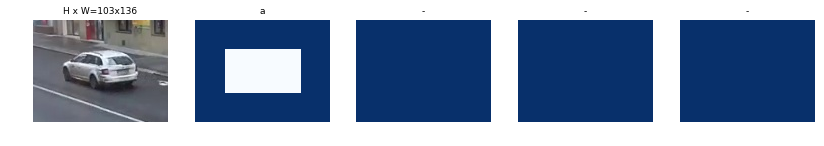

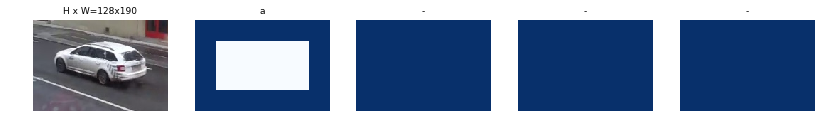

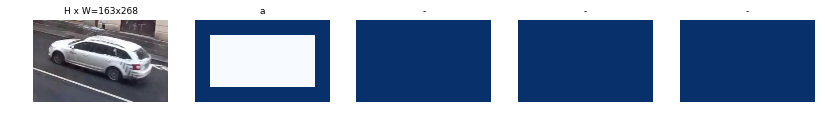

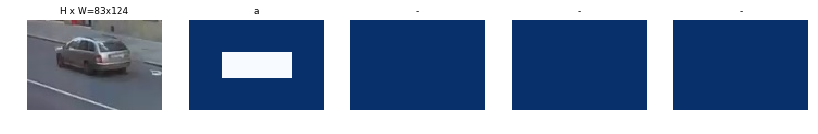

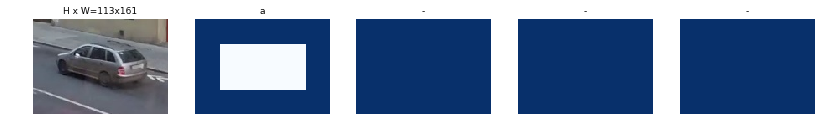

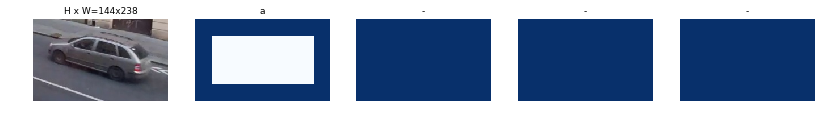

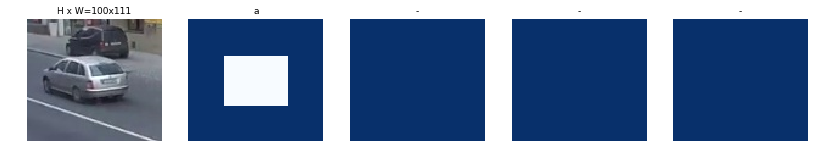

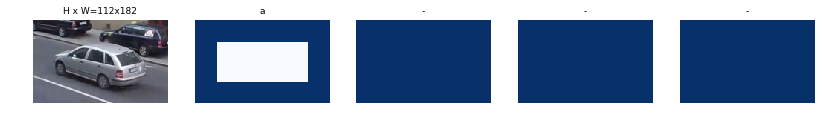

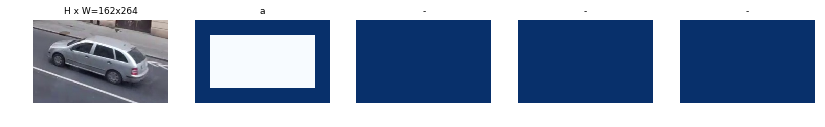

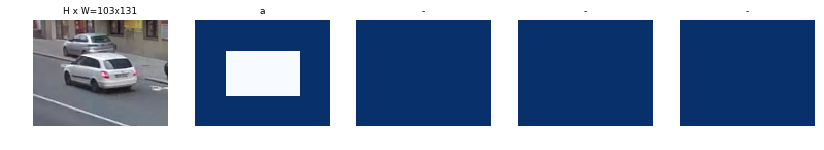

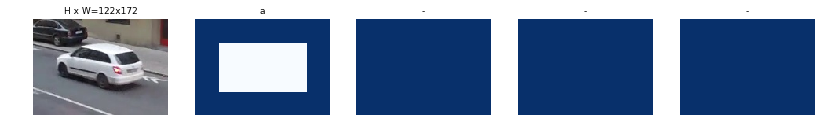

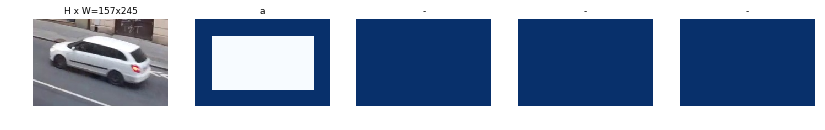

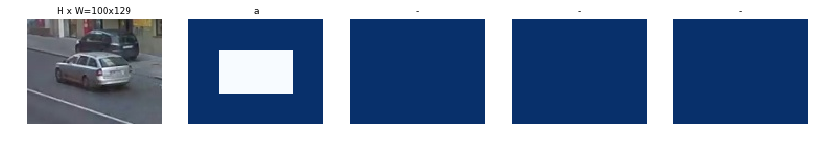

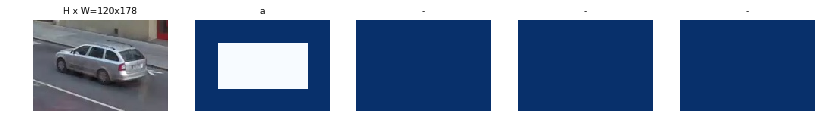

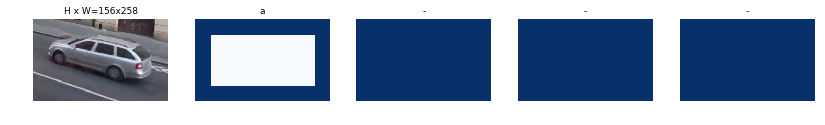

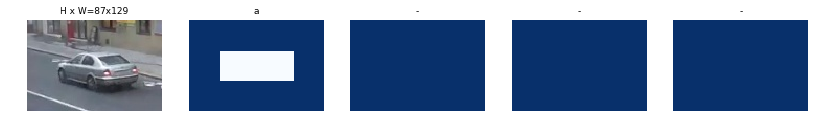

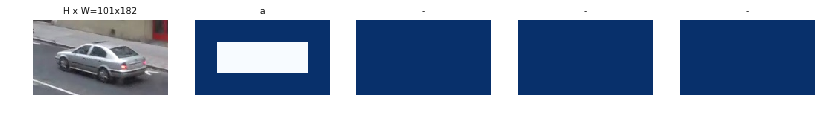

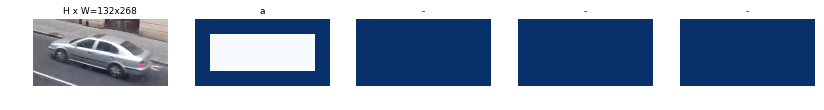

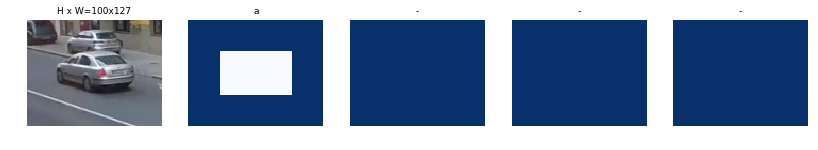

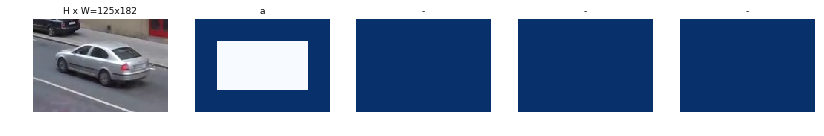

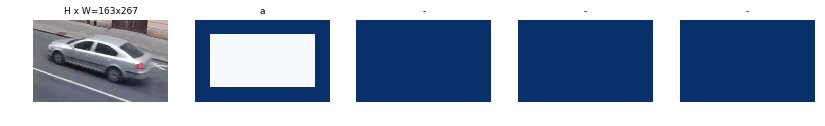

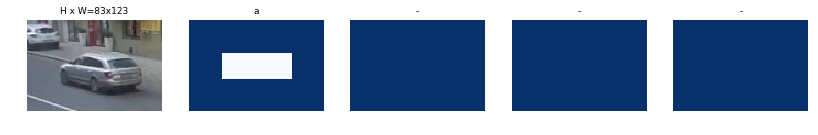

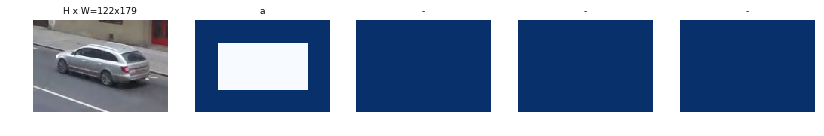

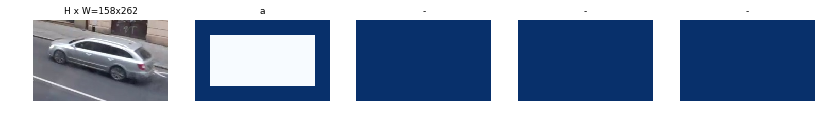

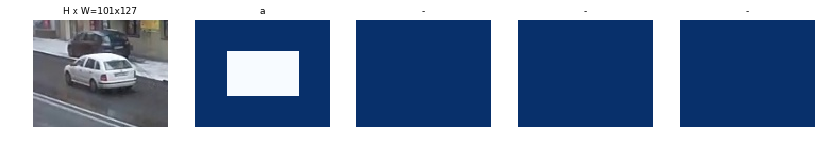

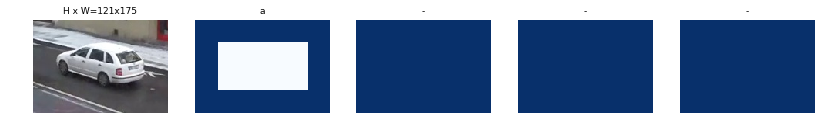

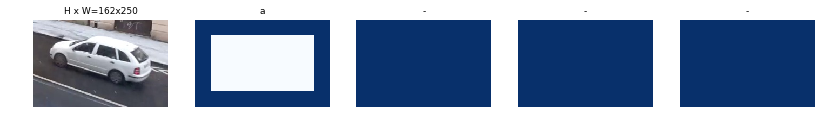

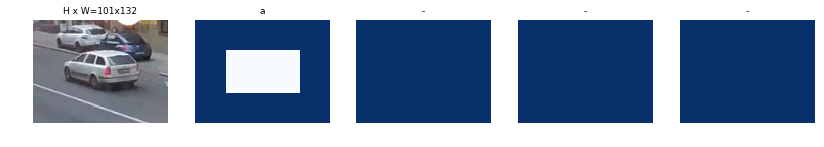

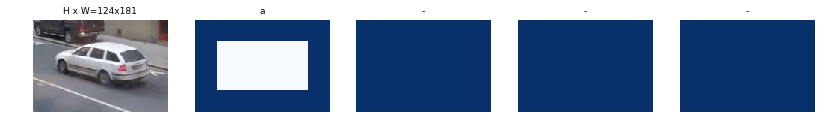

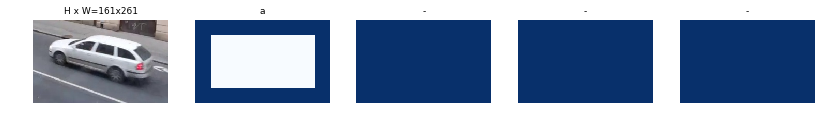

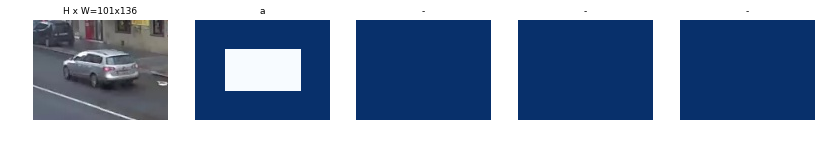

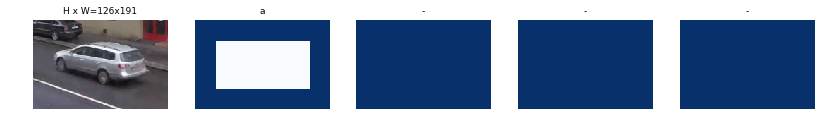

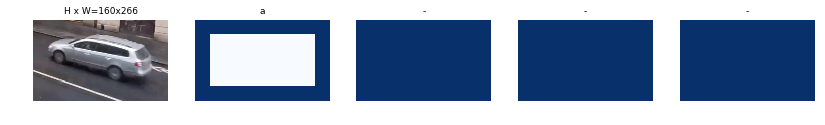

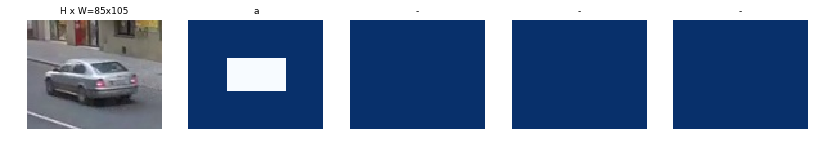

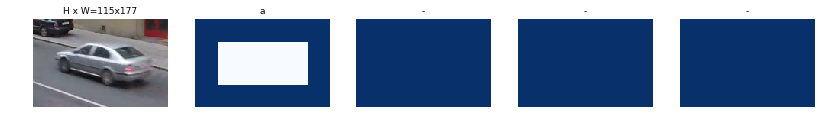

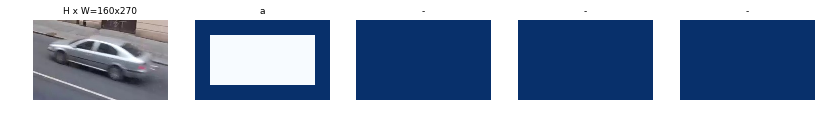

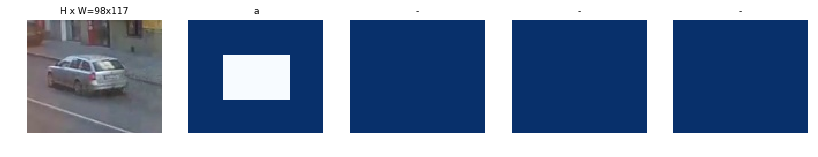

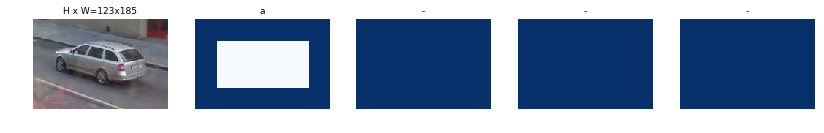

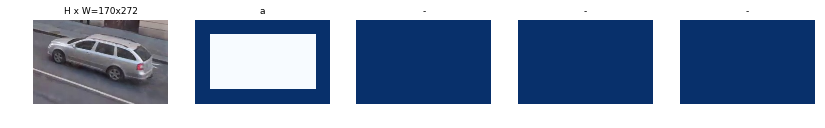

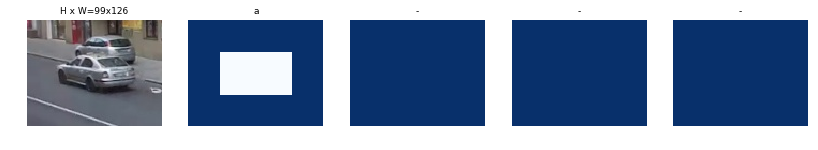

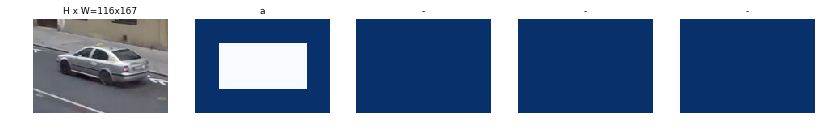

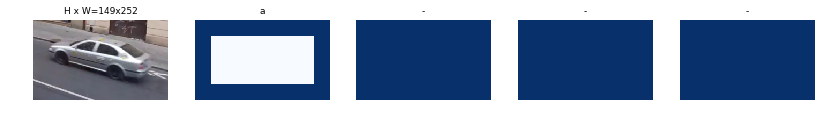

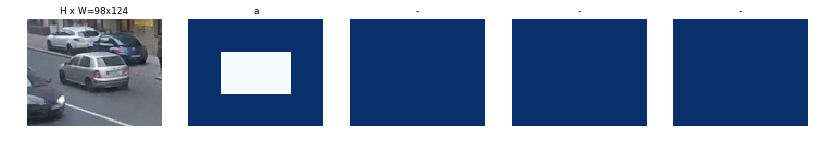

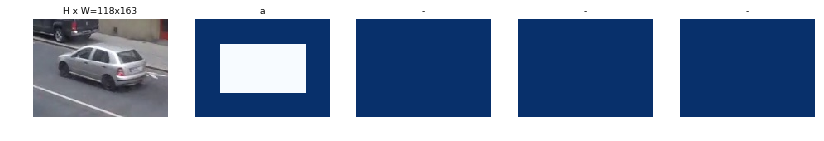

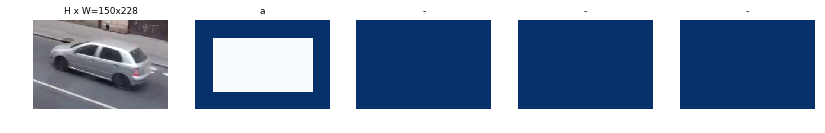

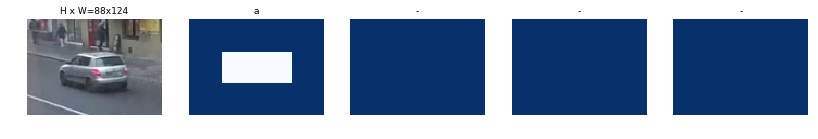

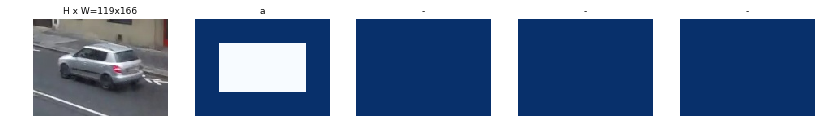

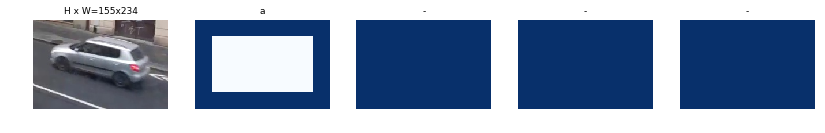

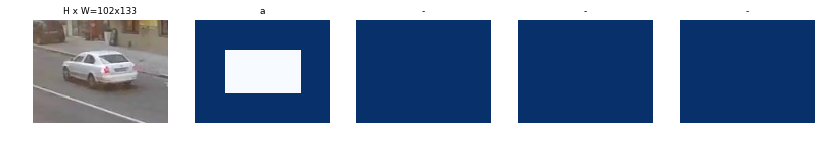

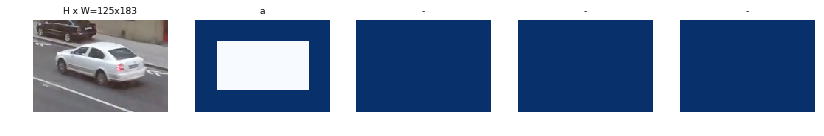

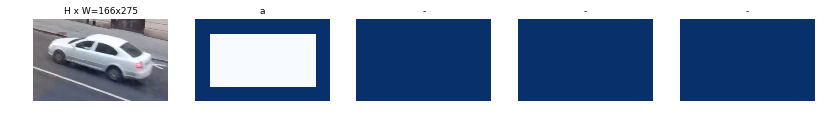

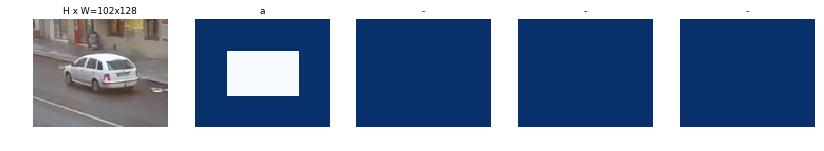

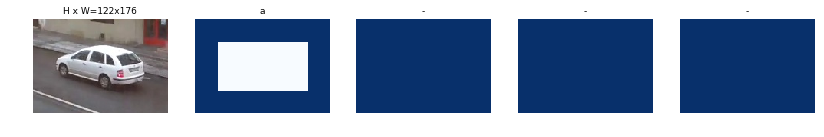

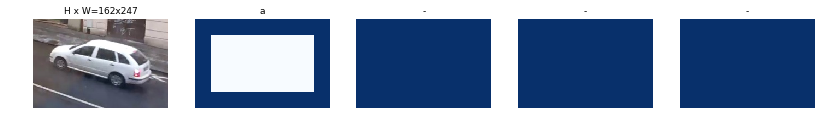

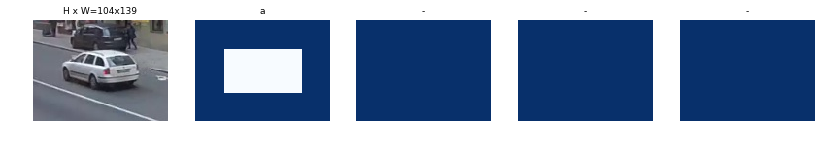

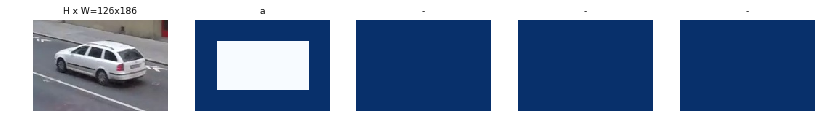

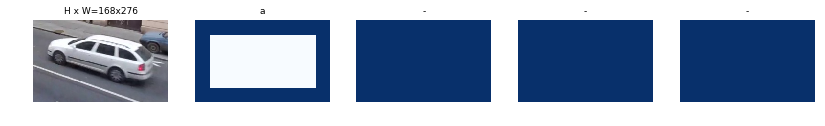

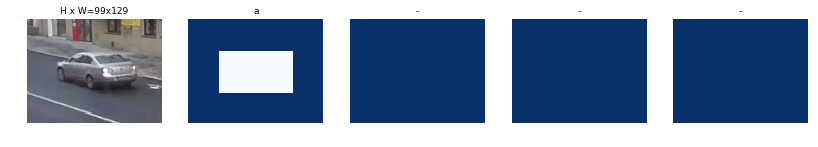

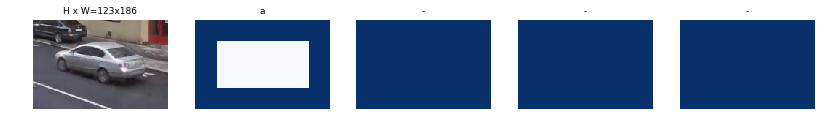

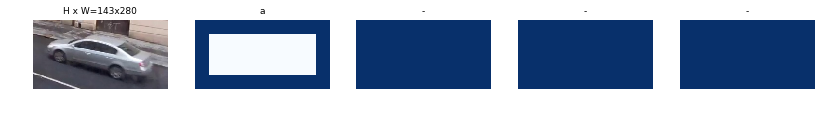

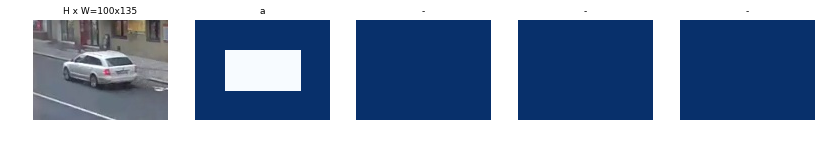

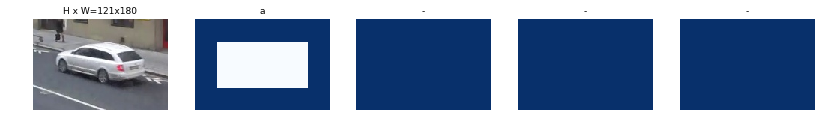

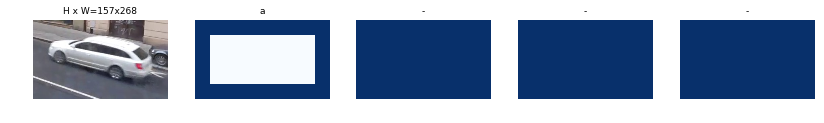

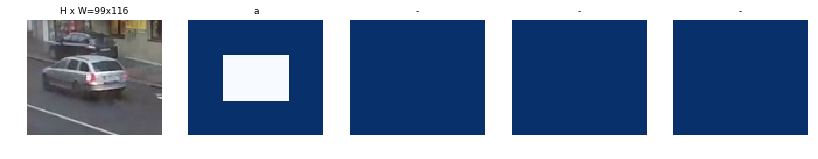

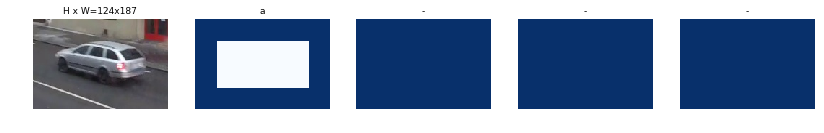

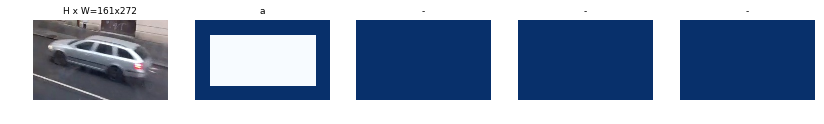

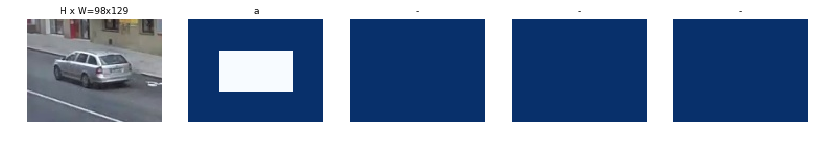

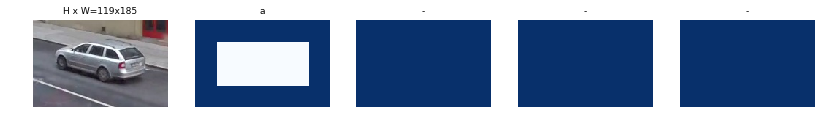

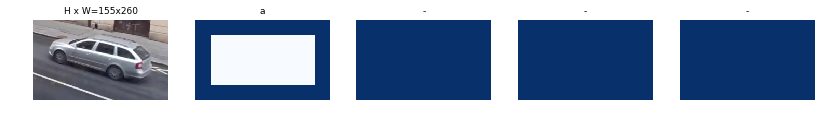

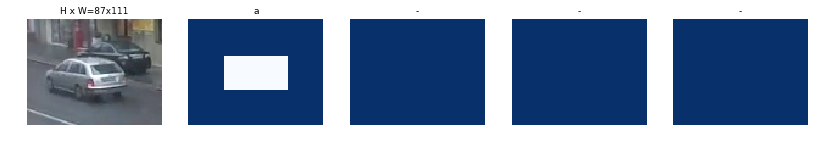

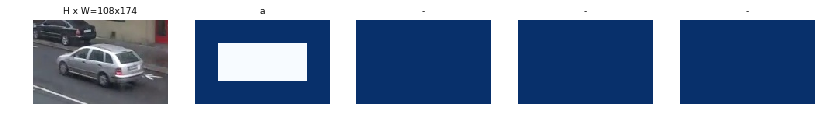

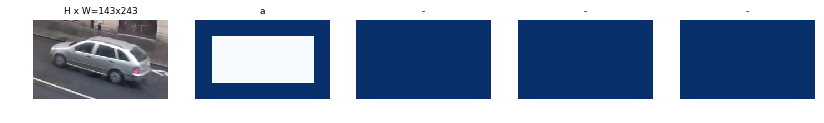

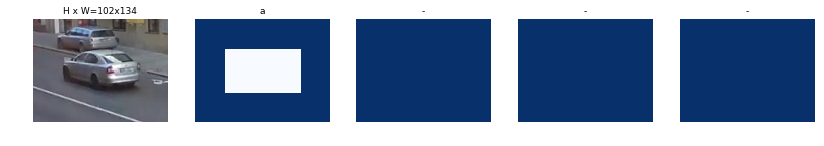

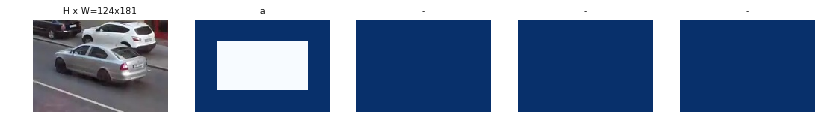

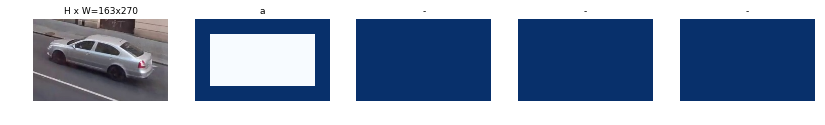

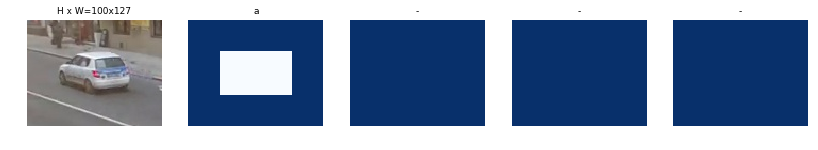

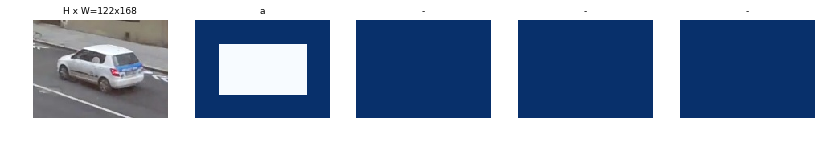

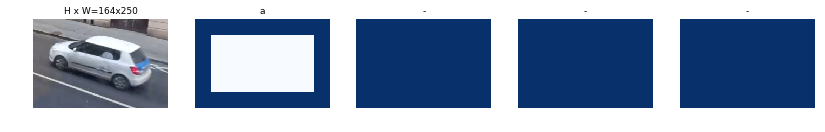

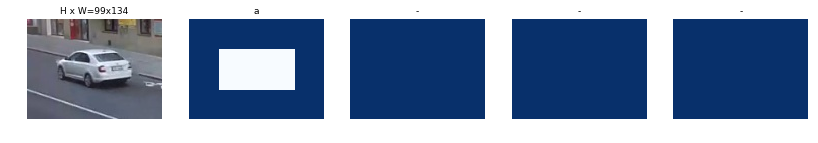

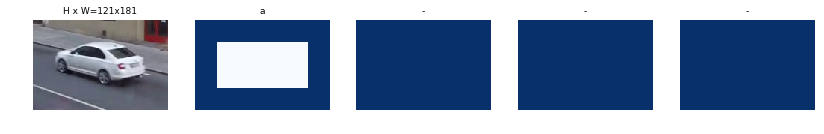

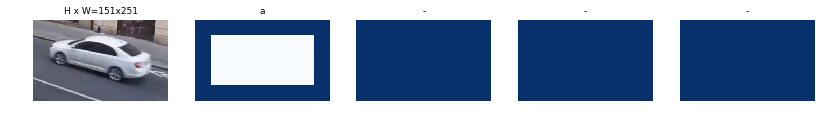

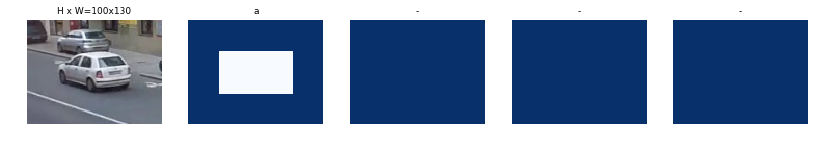

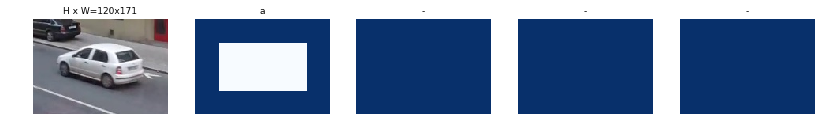

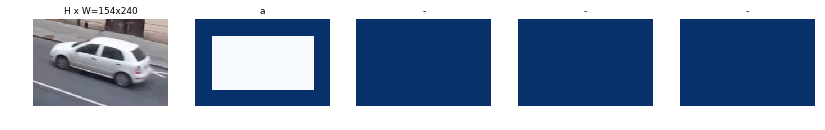

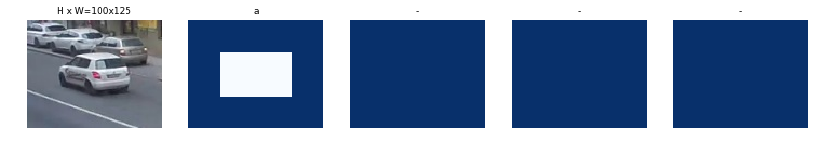

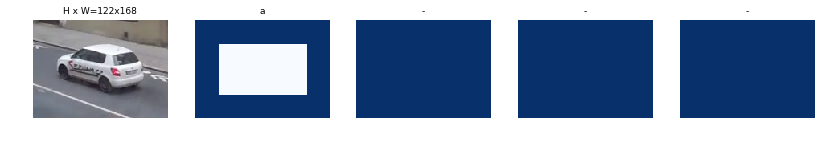

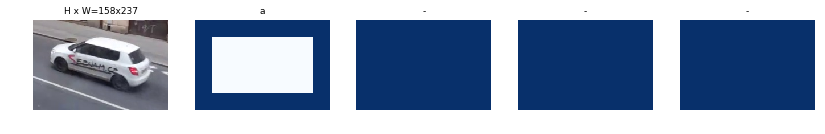

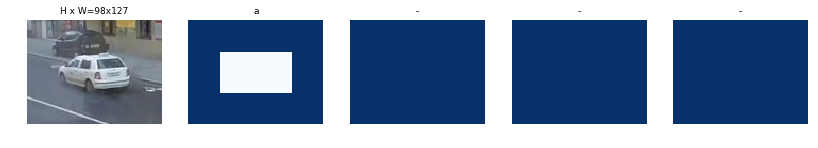

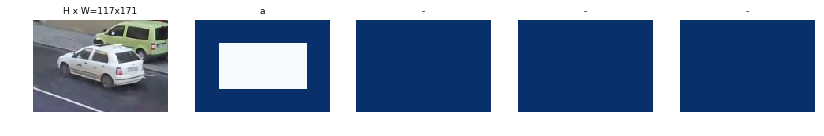

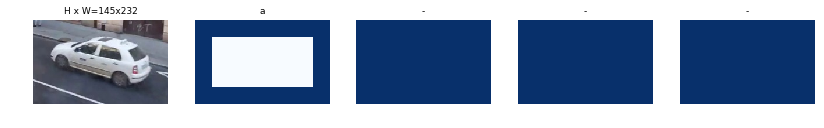

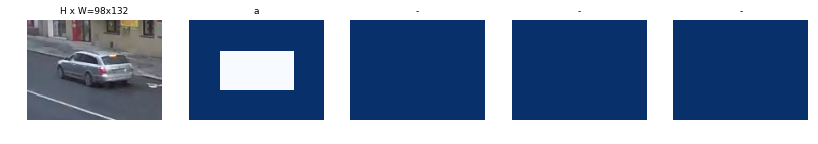

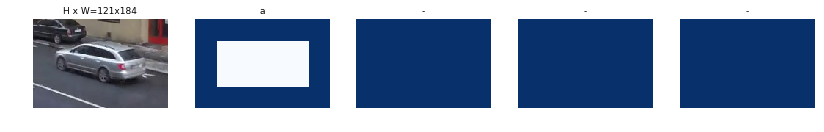

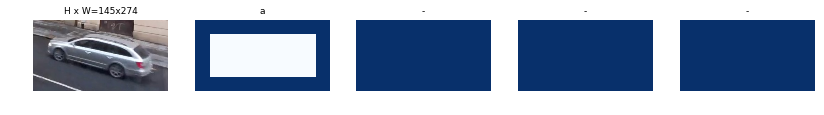

In [15]:
part='train'
#print(data.getMask3D(part,1))
for i in range(200,300):
    image = data.get_image(part,i)
    mask,y=data.load_mask(part,i)
    visualize.display_top_masks(image, mask, y, 'cars')